# Randon Forest Model wwith TF-IDF and Bag of words

In [1]:
# file path exist
import os.path
from os import path

# translator
import googletrans
from googletrans import Translator

# pandas
import pandas as pd

# preprocessing of text
import re
import string


# word tokenizer by nltk
from nltk import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stopwords (Remove buzz words)
from nltk.corpus import stopwords

# split data into train and test
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# RFM classifier from scikit learn
from sklearn.ensemble import RandomForestClassifier

# Tf-idf feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [2]:
# For English data
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
df = pd.read_csv(filename + '.csv',  
               delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)
data = df

In [3]:
# Same sentence after translation
data.Text[3]

"'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के गेट पर आधा नंगा होकर किया प्रदर्शन  पप्पू यादव ने बुलंद की\\xa0आवाज"

### Class count

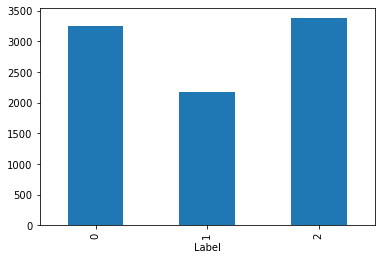

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [5]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [6]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [7]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [8]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

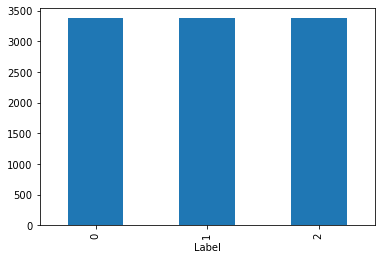

In [9]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [10]:
data.Label.value_counts()

2    3375
0    3374
1    3374
Name: Label, dtype: int64

In [11]:
data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'@neerajkumarmlc जदयू में अगर छात्रों का कोई स...,0
1,'भारतीय क्रिकेटर सुरैश रैना ने सुशांत सिंह राज...,0
2,'माशाअल्लाह डॉ कफ़ील मथुरा जेल से रिहा हुए ख़ु...,1
3,'@shweta4nation भारतीय जनता पार्टी ज़िंदाबाद,0
4,'@ShahidM66407204 @LAMStandley @ImranKhanPTI A...,2
...,...,...
10118,'@AbhiGup50627237 सुशांत सिंह राजपूत को न्याय ...,0
10119,'@ashutosh83B @BJP4India @INCIndia @SatyaHindi...,0
10120,'बदलो सरकार बदलो बिहार रेयाजुल हक़ राजू भाई ...,0
10121,'बेशक अल्लाह बड़ा रेहम करने वाला हे रहमतुल आ...,1


### Data Preprocessing

In [13]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [14]:
data.shape

(10123, 2)

In [15]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [16]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [17]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [18]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [19]:
# Removing Stopwords
stoplist=open("Devanagari/stopwords.txt","r")

In [20]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [21]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [22]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,Label,0,1,2,Category_id
0,neerajkumarmlc जदयू में अगर छात्रों का कोई सुन...,"[neerajkumarmlc, जदयू, में, अगर, छात्रों, का, ...",0,1,0,0,0
1,भारतीय क्रिकेटर सुरैश रैना ने सुशांत सिंह राजप...,"[भारतीय, क्रिकेटर, सुरैश, रैना, ने, सुशांत, सि...",0,1,0,0,0
2,माशाअल्लाह डॉ कफ़ील मथुरा जेल से रिहा हुए ख़ुश...,"[माशाअल्लाह, डॉ, कफ़ील, मथुरा, जेल, से, रिहा, ...",1,0,1,0,1
3,shweta4nation भारतीय जनता पार्टी ज़िंदाबाद,"[shweta4nation, भारतीय, जनता, पार्टी, ज़िंदाबाद]",0,1,0,0,0
4,shahidm66407204 lamstandley imrankhanpti abe c...,"[shahidm66407204, lamstandley, imrankhanpti, a...",2,0,0,1,2
5,दिशा सालियान और सुशांत सिंह राजपूत की हत्याओं ...,"[दिशा, सालियान, और, सुशांत, सिंह, राजपूत, की, ...",0,1,0,0,0
6,🙏 जय श्री राम 🚩 🇮🇳 भारत माता कि जय ✊ 🛕 हिंदू ह...,"[🙏, जय, श्री, राम, 🚩, 🇮🇳, भारत, माता, कि, जय, ...",0,1,0,0,0
7,aliitweeter akhileshpsingh जेहादी साले तुम ऐसी...,"[aliitweeter, akhileshpsingh, जेहादी, साले, तु...",2,0,0,1,2
8,सुशांत सिंह राजपूत की साईकोलॉजिकल ऑटोप्सी cbi ...,"[सुशांत, सिंह, राजपूत, की, साईकोलॉजिकल, ऑटोप्स...",0,1,0,0,0
9,ankita lokhande ने बताया सुशांत सिंह राजपूत का...,"[ankita, lokhande, ने, बताया, सुशांत, सिंह, रा...",0,1,0,0,0


In [23]:
# Removing empty rows after tokenization

In [24]:
data = data[data.tokens != '']

In [25]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

# RFM - TFIDF

In [26]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.Label
features.shape

(10123, 33061)

In [27]:
data.Label.value_counts()

2    3375
0    3374
1    3374
Name: Label, dtype: int64

In [28]:
# Spliting data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.10,shuffle = True, random_state=42)

In [29]:
# Generate model
model1 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=32)
clf = model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

### RFM - Showing some prediction

In [30]:
# Prediction
translator = Translator()

In [32]:
# 0
hin_text =  [" समाज वादी  पार्टी  जिंदाबाद "]
print(clf.predict(vectorizer.transform(hin_text)))

['0']


In [33]:
# 2
hin_text =  ["'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"]
print(clf.predict(vectorizer.transform(hin_text)))

['0']


In [34]:
# 1
hin_text =  ["इसलाम सुंदर है"]
print(clf.predict(vectorizer.transform(hin_text)))

['0']


In [35]:
# 2
texts = ["@_ROB_29 If this was a Muslim girl in Afghanistan you'd call her a terrorist"]
print(clf.predict(vectorizer.transform(texts)))

['0']


In [36]:
# 0
texts = ["Sachin: Once there was a fight between Yusuf and Bhajji. Sehwag: Paji, was he Muhammad Yusuf or Yusuf Youhana at that time. This man will not let him live even after retirement."]
print(clf.predict(vectorizer.transform(texts)))

['0']


### RFM - Displaying false-positive rate (FPR) and true positive rate (TPR)

Random Forest Method


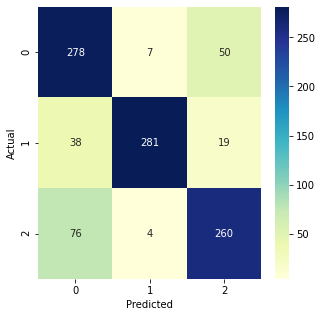

In [37]:
# confusion matrix
print("Random Forest Method")
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [38]:
results1 = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :')
print(results1) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[278   7  50]
 [ 38 281  19]
 [ 76   4 260]]
Accuracy Score : 0.8084896347482725
Report : 
              precision    recall  f1-score   support

           0       0.71      0.83      0.76       335
           1       0.96      0.83      0.89       338
           2       0.79      0.76      0.78       340

    accuracy                           0.81      1013
   macro avg       0.82      0.81      0.81      1013
weighted avg       0.82      0.81      0.81      1013



### RFM K-fold

In [39]:
import random
# Creating model
model1 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=32)

# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model1, features, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Random Forest with BOW: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )



Random Forest with BOW: 
1 0.8144126357354393
2 0.8144126357354393
3 0.8045409674234946
4 0.7885375494071146
5 0.8063241106719368
6 0.8231225296442688
7 0.791501976284585
8 0.817193675889328
9 0.8231225296442688
10 0.8033596837944664
 Average Accuracy : 0.8086528294230341


# RFM - BOW

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
features3 = count_vect.fit_transform(data.Text_Final).toarray()
labels = data.Label
features3.shape

(10123, 9071)

In [41]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features3, labels, data.index, test_size=0.10, shuffle = True, random_state=42)

In [42]:
# generate Linear SVM model
model3 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=32)
clf3 = model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

### RFM - BOW - Showing some prediction

In [43]:
# Prediction
translator = Translator()

In [45]:
# 0
hin_text =  [" समाज वादी  पार्टी  जिंदाबाद "]
print(clf3.predict(count_vect.transform(hin_text)))

['0']


In [46]:
# 2
hin_text =  ["'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"]
print(clf3.predict(count_vect.transform(hin_text)))

['0']


In [47]:
# 1
hin_text =  ["इसलाम सुंदर है"]
print(clf3.predict(count_vect.transform(hin_text)))

['0']


In [48]:
# 2
texts = ["@_ROB_29 If this was a Muslim girl in Afghanistan you'd call her a terrorist"]
print(clf3.predict(count_vect.transform(texts)))

['0']


In [49]:
# 0
texts = ["Sachin: Once there was a fight between Yusuf and Bhajji. Sehwag: Paji, was he Muhammad Yusuf or Yusuf Youhana at that time. This man will not let him live even after retirement."]
print(clf3.predict(count_vect.transform(texts)))

['0']


###  RFM - BOW - Displaying false-positive rate (FPR) and true positive rate (TPR)

                     RFM - BOW


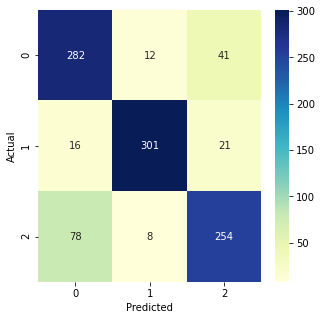

In [50]:
from sklearn.metrics import confusion_matrix
print("                     RFM - BOW")
conf_mat = confusion_matrix(y_test, y_pred3)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - BOW - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [51]:
results3 = confusion_matrix(y_test, y_pred3)
print ('Confusion Matrix :')
print(results3) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred3))
print ('Report : ')
print (classification_report(y_test, y_pred3))

Confusion Matrix :
[[282  12  41]
 [ 16 301  21]
 [ 78   8 254]]
Accuracy Score : 0.8262586377097729
Report : 
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       335
           1       0.94      0.89      0.91       338
           2       0.80      0.75      0.77       340

    accuracy                           0.83      1013
   macro avg       0.83      0.83      0.83      1013
weighted avg       0.83      0.83      0.83      1013



### RFM with BOW Kfold

In [52]:
# model
model3 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=32)

# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model3, features3, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Random Forest with BOW: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )

Random Forest with BOW: 
1 0.8381046396841066
2 0.8094768015794669
3 0.8084896347482725
4 0.8320158102766798
5 0.8211462450592886
6 0.8438735177865613
7 0.7934782608695652
8 0.8221343873517787
9 0.817193675889328
10 0.8122529644268774
 Average Accuracy : 0.8198165937671925
